In [10]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
#
# Code adapted from QizGloria team, Qiskit Camp Europe 2019, updated by 
# Team Ube Pancake, Qiskit Summer Jam 2020

In [11]:
import torch
from torch.autograd import Function
import torch.optim as optim

In [12]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,execute
from qiskit.circuit import Parameter
from qiskit import Aer
import qiskit
import numpy as np

In [13]:
from tqdm import tqdm

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
np.random.seed = 42

NUM_QUBITS = 2
NUM_SHOTS = 10000
SIMULATOR = Aer.get_backend('qasm_simulator')

Define function to translate Q-Circuit parameters from pytorch back to QISKIT

In [16]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

## 2. Define Quantum Circuit Functions

In [17]:
# Define QFT rotations
def qft_rotations(circuit, theta, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(theta / 2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, theta, n)

# Define swap functions that reorder the readout (optional)
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

# Total QFT circuit including hadamards, controlled-unitary rotations, and final swap gates
def qft(circuit, theta, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, theta, n)
    swap_registers(circuit, n)
    return circuit



## 3. Contruct QuantumCircuit QFT Class

In [18]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.theta = Parameter('Theta')
        
        # make QFT circuit
        self.circuit = qft(self.circuit, self.theta, n_qubits)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
    def expectation(self, counts, shots, nr_qubits): #calculate expectation for one qubit pair
        expects = 0
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects 
    
    def bind(self, parameters):
        self.theta = to_numbers(parameters)
        self.circuit.data[1][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,
                          self.backend,
                          shots=self.shots)
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.expectation(counts,self.shots,self.n_qubits)

Expected value for rotation [pi/4]: [-0.005   0.0094]


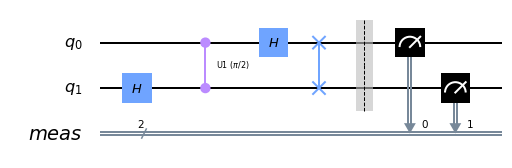

In [20]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/2]))))
circuit.circuit.draw(output='mpl', filename='Figures/qft-circuit.jpg')

### TorchCircuit()

A pytorch layer always has two functions. One for the forward pass and one for the backward pass. The forward pass simply takes the Quantum Circuits variational parameters from the previous pytorch layer and runs the circuit on the defined hardware (defined in `QiskitCircuit.run()`) and returns the measurements from the quantum hardware.
These measurements will be the inputs of the next pytorch layer.

The backward pass returns the gradients of the quantum circuit. In this case here it is finite difference.

the `forward_tensor` is saved from the forward pass. So we just have to do one evaluation of the Q-Circuit in the backpass for the finite difference.

The `gradient` variable here is as well hard coded to 3 parameters. This should be updated in the future and made more general.

The loop `for k in range(len(input_numbers)):` goes through all the parameters (in this case 3), and shifts them by a small $\epsilon$. Then it runs the circuit and takes the diefferences of the ouput for the parameters $\Theta$ and $\Theta + \epsilon$. This is the finite difference. 

In [576]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = 0.01
        
        forward_tensor, i = ctx.saved_tensors
        input_numbers = to_numbers(i[0])
        gradients = []
        
        for k in range(len(input_numbers)):
            input_eps = input_numbers
            input_eps[k] = input_numbers[k] + eps
            exp_value = ctx.QiskitCirc.run(torch.tensor(input_eps))[0]
            gradient = (exp_value - forward_tensor[0][0].item())#/eps
            gradients.append(gradient)
            
        print('gradient = {}'.format(gradients))
        result = torch.tensor([gradient])
#         print(result)

        return result.float() * grad_output.float()

In [577]:
x = torch.tensor([[np.pi/2]], requires_grad=True)
# x = torch.tensor([[0.0, 0.0, 0.0]], requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
y1.backward()
print(x.grad)

RuntimeError: grad can be implicitly created only for scalar outputs

### Test the Quantum Circuit separately

This example is simply to test the QC with a pytorch optimizer

We define a cost function and a target expectation value (here -1). The cost is the square distance from the target value.

`x` is the initialization of the parameters. Here again, this was hard coded such that every angle starts at $\pi / 4$.

The rest is standard pytorch optimization

  4%|███▎                                                                              | 4/100 [00:00<00:05, 16.94it/s]

gradient = [-0.0007999999999999952]
gradient = [0.007599999999999996]
gradient = [0.01100000000000001]
gradient = [-0.01960000000000009]


  8%|██████▌                                                                           | 8/100 [00:00<00:05, 17.15it/s]

gradient = [0.012800000000000006]
gradient = [0.008600000000000024]
gradient = [0.0018000000000000516]
gradient = [-0.009399999999999964]


 12%|█████████▋                                                                       | 12/100 [00:00<00:05, 17.32it/s]

gradient = [-0.026200000000000057]
gradient = [0.02460000000000004]
gradient = [0.019200000000000078]
gradient = [-0.007200000000000012]


 16%|████████████▉                                                                    | 16/100 [00:00<00:04, 17.41it/s]

gradient = [-0.003599999999999992]
gradient = [-0.016400000000000053]
gradient = [0.0005999999999999894]
gradient = [0.010599999999999998]


 20%|████████████████▏                                                                | 20/100 [00:01<00:04, 17.03it/s]

gradient = [-0.012800000000000061]
gradient = [-0.0009999999999999731]
gradient = [0.0048000000000000265]
gradient = [-0.019400000000000084]


 22%|█████████████████▊                                                               | 22/100 [00:01<00:04, 16.88it/s]

gradient = [0.00040000000000001146]
gradient = [0.015199999999999991]
gradient = [-0.018199999999999994]
gradient = [-0.00020000000000003348]


 28%|██████████████████████▋                                                          | 28/100 [00:01<00:04, 16.70it/s]

gradient = [0.006400000000000017]
gradient = [-0.016599999999999976]
gradient = [0.004200000000000009]
gradient = [0.016000000000000014]


 30%|████████████████████████▎                                                        | 30/100 [00:01<00:04, 16.81it/s]

gradient = [0.0050000000000000044]
gradient = [-0.005800000000000027]
gradient = [0.019200000000000078]
gradient = [0.008000000000000035]


 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:03, 17.03it/s]

gradient = [0.009800000000000003]
gradient = [-0.003199999999999953]
gradient = [0.013799999999999979]
gradient = [-0.0194]


 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:03, 17.23it/s]

gradient = [0.00799999999999998]
gradient = [0.017800000000000066]
gradient = [0.006599999999999939]
gradient = [-0.016399999999999998]


 44%|███████████████████████████████████▋                                             | 44/100 [00:02<00:03, 17.18it/s]

gradient = [-0.0017999999999999683]
gradient = [-0.0005999999999999617]
gradient = [0.013600000000000029]
gradient = [0.01579999999999998]


 48%|██████████████████████████████████████▉                                          | 48/100 [00:02<00:03, 17.21it/s]

gradient = [0.010600000000000026]
gradient = [0.008600000000000052]
gradient = [-0.010599999999999998]
gradient = [-0.019600000000000062]


 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:02, 17.21it/s]

gradient = [-0.013200000000000045]
gradient = [-0.013000000000000012]
gradient = [0.0030000000000000027]
gradient = [-5.551115123125783e-17]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:03<00:02, 17.31it/s]

gradient = [0.024800000000000072]
gradient = [0.00919999999999993]
gradient = [0.006600000000000078]
gradient = [0.0063999999999999335]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:03<00:02, 17.15it/s]

gradient = [-0.019600000000000034]
gradient = [0.01200000000000001]
gradient = [0.013600000000000029]
gradient = [-0.0007999999999999396]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:03<00:02, 17.17it/s]

gradient = [0.01979999999999993]
gradient = [0.008200000000000013]
gradient = [-0.028199999999999947]
gradient = [-0.0010000000000000009]


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:03<00:01, 17.29it/s]

gradient = [0.022399999999999975]
gradient = [-0.012200000000000016]
gradient = [-0.0050000000000000044]
gradient = [-0.00520000000000001]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:04<00:01, 17.28it/s]

gradient = [0.013799999999999979]
gradient = [-0.013999999999999957]
gradient = [-0.012200000000000016]
gradient = [-0.009199999999999986]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:04<00:01, 17.27it/s]

gradient = [0.014599999999999946]
gradient = [0.01820000000000002]
gradient = [0.017799999999999955]
gradient = [-0.0232]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:04<00:01, 17.13it/s]

gradient = [0.0033999999999999586]
gradient = [-0.005399999999999988]
gradient = [-0.013999999999999957]
gradient = [0.0019999999999999463]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:04<00:00, 17.05it/s]

gradient = [-0.0023999999999999855]
gradient = [0.005600000000000022]
gradient = [0.01319999999999999]
gradient = [0.0005999999999999617]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:05<00:00, 17.33it/s]

gradient = [-0.00379999999999997]
gradient = [0.017600000000000005]
gradient = [-0.022199999999999998]
gradient = [-0.004800000000000054]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:05<00:00, 17.34it/s]

gradient = [0.044600000000000084]
gradient = [0.003400000000000014]
gradient = [-0.0030000000000000027]
gradient = [-0.002400000000000041]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:05<00:00, 17.08it/s]

gradient = [-0.008399999999999963]
gradient = [0.004599999999999993]
gradient = [0.007200000000000012]
gradient = [-0.01560000000000003]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.11it/s]

gradient = [-0.005799999999999944]
gradient = [0.009799999999999975]
gradient = [-0.006399999999999989]
gradient = [-0.0072000000000000675]


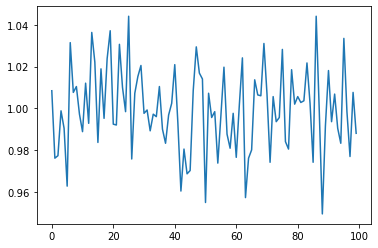

In [480]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)
    return torch.abs(qc(x) - target) ** 2, expval

x = torch.tensor([[np.pi/4]], requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval.item())
#     print(loss.item())

plt.plot(loss_list)
    
# print(circuit(phi, theta))
# print(cost(x))

### MNIST in pytorch

In [462]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Load MNIST

In this code we can not handle batches yet.
This should be implemented as well

In [463]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

batch_size_train = 1
batch_size_test = 1
learning_rate = 0.01
momentum = 0.5
n_datapoints = 100

torch.backends.cudnn.enabled = False

transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets #get labels
labels = labels.numpy()
idx1 = np.where(labels == 0) #search all zeros
idx2 = np.where(labels == 1) # search all ones
idx = np.concatenate((idx1[0][0:n_datapoints//2],idx2[0][0:n_datapoints//2])) # concatenate their indices
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

print(mnist_trainset)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

Dataset MNIST
    Number of datapoints: 100
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


### Define Neural Network with Q-node

This NN is  2 layers of ConvNN and a fully connected layer, with a Q-Node as a classifier.

In [471]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
        self.qft = TorchCircuit.apply

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
#         return F.softmax(x)
        x = np.pi*torch.tanh(x)
        x = self.qft(x) # This is the q node
        x = (x+1)/2 # Translate expectation values [-1,1] to labels [0,1]
        x = torch.cat((x, 1-x), -1)
        return x

In [472]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# optimizer = optim.Adam(network.parameters(), lr=learning_rate)

### Training loop

standard pytorch training loop.
- Load data from train_loader. Which is this case a single example each step.
- Forward pass through NN
- Caluculate loss
- Backprop and optimize

In [473]:
epochs = 20
loss_list = []

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(batch_idx)
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        # Calculating loss
        loss = F.nll_loss(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.5005
Training [10%]	Loss: -0.4999
Training [15%]	Loss: -0.5007
Training [20%]	Loss: -0.4998
Training [25%]	Loss: -0.5002
Training [30%]	Loss: -0.5004
Training [35%]	Loss: -0.5009
Training [40%]	Loss: -0.5001
Training [45%]	Loss: -0.5000
Training [50%]	Loss: -0.4997


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

### Test accuracy of NN

The outcome is not always the same because the prediction is probabilistic.

In [296]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(train_loader):
    number +=1
    output = network(data)
    output = (output>0.5).float()
    accuracy += (output[0][1].item() == target[0].item())*1
    
print("Performance on test data is is: {}".format(accuracy/number))    

Performance on test data is is: 0.78


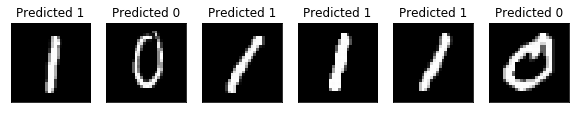

In [299]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        if count == n_samples_show:
            break
        output = network(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1